## Operator-Only Energy Matrix Predictions

We have generally considered the "preferred" means of making predictions to involve mutations of the full promoter so that a single binding energy fixed point can be used to set the scaling factor for the matrices. Here, I would like to explore the method of mutating only the operator and using two fixed points to set the scaling factor. This is a less flexible method, it is generally more accurate. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import sys
import pandas as pd
import matplotlib.lines as mlines
from sklearn.metrics import r2_score


# Import the project utils
sys.path.insert(0, '../utilities/')
import sortseq_utils as sortseq
import mwc_induction_utils as mwc
mwc.set_plotting_style()

# Set color scheme
colors=sns.color_palette('RdPu_r', 6)[1:]
colors_alt=sns.color_palette('Blues')
colors_qual=sns.color_palette(
    ['#bf0087', '#e5b600', '#40ac00', '#5233ea', '#bf3800', '#00acac'])

sns.set_palette(colors_qual)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

The binding energy calculated for a sequence by an energy matrix, $\Delta \varepsilon_R$, has a linear relationship with the energy calculated from the raw matrix, $\Delta \varepsilon_\text{mat}$, and the wild-type binding energy, $\Delta \varepsilon_\text{wt}$. This relationship is given by the equation

\begin{equation}
  \Delta \varepsilon_R = \alpha \Delta \varepsilon_\text{mat} + \Delta \varepsilon_\text{wt},
\end{equation}

where $\alpha$ is a scaling factor that converts the raw energy matrix into $k_BT$ units. When the entire promoter is mutated for Sort-Seq, which in this case includes the RNAP binding site and the operator, one can use the thermodynamic model for the fold-change of the promoter to fit for the value of $\alpha$. However, when only the operator is mutated, there is insufficient information available to perform such a fit. Instead, the value of $\alpha$ must be calibrated using known energies for specific binding sequences. Here, we will use the measured values of our single base-pair mutants to calibrate $\alpha$ for the matrix generated using O1 and $R = 130$, and the matrix using O2 and $R = 130$. 

We will use the function find_mult(), imported from sortseq_utils.py, to find a scaling factor given an input sequence and its measured binding energy. Due to uncertainty in the matrix, the resulting scaling factor will vary depending on the input sequence. Thus, we will use several input sequences (i.e. the single bp mutant operators) to obtain a list of scaling factors, then remove outliers and average the values to find a single calibrated scaling factor. 

In [2]:
# Load matrix data
O1_mat = np.loadtxt('../../data/models/O1_only_1027_operator_MCMC_2', skiprows=1, usecols=[1, 2, 3, 4])
O2_mat = np.loadtxt('../../data/models/O2_only_1027_operator_MCMC_2', skiprows=1, usecols=[1, 2, 3, 4])

# Fix matrices so wild-type energy is 0
O1_wt = 'AATTGTGAGCGGATAACAATT'
O2_wt = 'aaatgtgagcgagtaacaacc'.upper()
O1_mat = np.array(sortseq.fix_wt(O1_mat, O1_wt))
O2_mat = np.array(sortseq.fix_wt(O2_mat, O2_wt))

# Load mutant info and initialize dataframe
mut_ops = pd.read_csv('../../data/Onew_mutants_list.csv')
measured = pd.read_csv('../../data/Onew_TF_titration_nonlinear_regression_summary.csv', index_col=0)

# Create the dataframe we will be using for calculations
df = measured

mut_seqs = np.array([mut_ops['seq'][mut_ops['ID']=='mut' + mut[-3:]].values[0]\
                     for mut in measured['operator'].unique()])
df['seq']=mut_seqs

In [3]:
# Define wild-type energies
O1_en = -15.3 # k_BT
O2_en = -13.9 # k_BT

O1_mults = [sortseq.find_mult(df['seq'][df['operator']==mut].values[0],\
                   df['energy_kBT'][df['operator']==mut].values[0], O1_mat, O1_en) for mut in df['operator']]

O2_mults = [sortseq.find_mult(df['seq'][df['operator']==mut].values[0],\
                   df['energy_kBT'][df['operator']==mut].values[0], O2_mat, O2_en) for mut in df['operator']]

df['O1_multiplier'] = O1_mults
df['O2_multiplier'] = O2_mults

Here we should take a look at the first several rows of the dataframe to see what our distribution of scaling factors looks like. We will want to remove any obvious outliers. 

In [4]:
df[0:9]

,operator,energy_kBT,energy_kBT_std,seq,O1_multiplier,O2_multiplier
0,O1new005,-12.327153,0.041399,AATTGTGAGCGGAGAACAATT,12.779346,6.634524
1,O1new007,-15.379803,0.065059,AATTGTGAGCGCATAACAATT,-18.038716,72.911080
2,O1new008,-15.069734,0.051551,AATTGTGAGCGGATCACAATT,65.771433,97.738487
3,O1new009,-12.582220,0.054886,AATTGTGAGCGGAAAACAATT,13.396260,6.674871
4,O1new010,-11.382505,0.048934,AATTGCGAGCGGATAACAATT,11.697645,11.332970
5,O1new011,-12.428376,0.062848,AATTGTGAGGGGATAACAATT,13.741933,14.102503
6,O1new012,-13.079460,0.216505,AATTGTGAGCGGATATCAATT,13.314423,15.275515
7,O1new013,-10.175189,0.154056,AATTGTGAGCAGATAACAATT,14.116615,15.515457
8,O1new014,-10.698867,0.266212,AATTGTGAGAGGATAACAATT,11.935772,6.573019


Now we can determine the mean scaling factor obtained from the single bp mutants for the O1 energy matrix. 

(0, 20)

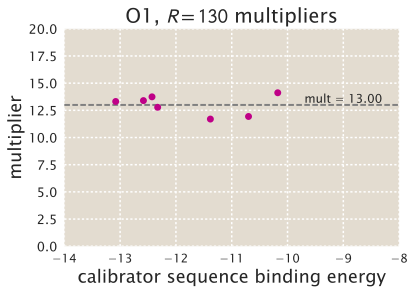

In [5]:
# Calculate mean scaling factor after removing outliers
O1_cal_mult = np.mean(df[0:9]['O1_multiplier'][(df[0:9]['energy_kBT']>-14) & (df[0:9]['energy_kBT']<60)])

# Plot all scaling factors overlaid with mean scaling factor
plt.axhline(O1_cal_mult, ls='--', color='gray')
plt.text(-9, O1_cal_mult + 0.2, 'mult = %0.2f' % O1_cal_mult, fontsize=12, ha='center')

plt.plot(df[0:9]['energy_kBT'], df[0:9]['O1_multiplier'], 'o')
plt.xlabel('calibrator sequence binding energy')
plt.ylabel('multiplier')
plt.title(r'O1, $R = 130$ multipliers')

plt.xlim(-14, -8)
plt.ylim(0, 20)

We can repeat this for the O2 energy matrix. 

(0, 20)

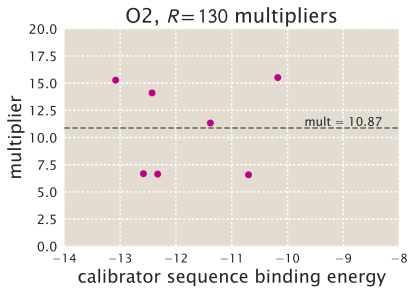

In [6]:
# Calculate mean scaling factor after removing outliers
O2_cal_mult = np.mean(df[0:9]['O2_multiplier'][(df[0:9]['energy_kBT']>-14) & (df[0:9]['energy_kBT']<60)])

# Plot all scaling factors overlaid with mean scaling factor
plt.axhline(O2_cal_mult, ls='--', color='gray')
plt.text(-9, O2_cal_mult + 0.2, 'mult = %0.2f' % O2_cal_mult, fontsize=12, ha='center')

plt.plot(df[0:9]['energy_kBT'], df[0:9]['O2_multiplier'], 'o')
plt.xlabel('calibrator sequence binding energy')
plt.ylabel('multiplier')
plt.title(r'O2, $R = 130$ multipliers')

plt.xlim(-14, -8)
plt.ylim(0, 20)

With these calibrated scaling factors in hand, we can now scale the matrices and compare predicted energy values against measured energy values. 

In [7]:
# Apply scaling factors to matrices

O1_mat = O1_cal_mult * O1_mat
O2_mat = O2_cal_mult * O2_mat

# Add columns to df showing predicted energies from O1 matrix and O2 matrix
O1_preds = [sortseq.binding_energy(seq, O1_mat, O1_en) for seq in df['seq']]
O2_preds = [sortseq.binding_energy(seq, O2_mat, O2_en) for seq in df['seq']]

df['O1_predictions'] = O1_preds
df['O2_predictions'] = O2_preds

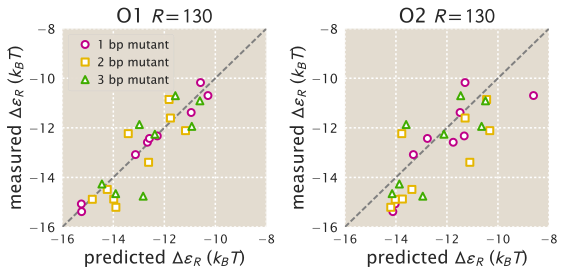

In [8]:
# Now let's plot.

fig, ax = plt.subplots(ncols=2, figsize=(8,4))

for a in ax:
    a.plot([-16, -4], [-16, -4], ls='--', color='gray')
    a.set_xlim(-16, -8)
    a.set_ylim(-16, -8)
    a.set_xlabel(r'predicted $\Delta \varepsilon_R$ ($k_BT$)')
    a.set_ylabel(r'measured $\Delta \varepsilon_R$ ($k_BT$)')

for name in df['operator'].unique():
    if name.startswith('O1new0'):
        ax[0].plot(df['O1_predictions'][df['operator']==name],\
                   df['energy_kBT'][df['operator']==name], 'o',\
                   markerfacecolor='white', markeredgecolor=colors_qual[0], markeredgewidth=2)
        ax[1].plot(df['O2_predictions'][df['operator']==name],\
                   df['energy_kBT'][df['operator']==name], 'o',\
                  markerfacecolor='white', markeredgecolor=colors_qual[0], markeredgewidth=2)
    elif name.startswith('O1new1'):
        ax[0].plot(df['O1_predictions'][df['operator']==name],\
                   df['energy_kBT'][df['operator']==name], 's',\
                   markerfacecolor='white', markeredgecolor=colors_qual[1], markeredgewidth=2)
        ax[1].plot(df['O2_predictions'][df['operator']==name],\
                   df['energy_kBT'][df['operator']==name], 's',\
                   markerfacecolor='white', markeredgecolor=colors_qual[1], markeredgewidth=2)
    elif name.startswith('O1new2'):
        ax[0].plot(df['O1_predictions'][df['operator']==name],\
                   df['energy_kBT'][df['operator']==name], '^',\
                  markerfacecolor='white', markeredgecolor=colors_qual[2], markeredgewidth=2)
        ax[1].plot(df['O2_predictions'][df['operator']==name],\
                   df['energy_kBT'][df['operator']==name], '^',\
                  markerfacecolor='white', markeredgecolor=colors_qual[2], markeredgewidth=2)
ax[0].set_title(r'O1 $R = 130$')
ax[1].set_title(r'O2 $R = 130$')

# Add legend
markers = ['o', 's', '^']
names = ['1 bp mutant', '2 bp mutant', '3 bp mutant']
ims = []
for i in range(3):
    ims.append(mlines.Line2D([], [], marker=markers[i], markeredgewidth=2,\
                             markerfacecolor='white', markeredgecolor=colors_qual[i],\
                             label=names[i], linestyle='None'))
ax[0].add_artist(ax[0].legend(handles=ims, loc='upper left', handletextpad=0, columnspacing=0.5, fontsize=12))


plt.tight_layout()

The calibrated scaling factor works very well for the O1 energy matrix predictions, with all data points clustering tightly around the diagonal. The predictions are not as successful for the O2 energy matrix, but we nevertheless see an improvement over the MCMC-inferred scaling factor (see plots in energy_matrix_comparisons.ipynb). For the main text, we only discuss the MCMC-inferred scaling factor, because it can be inferred without any additional measurements; however, it is useful to be aware that higher-quality predictions can be made using an operator-only mutation scheme and a scaling factor that is calibrated using a set of several energy measurements.